# multi-region cortex - BG - thalamus model

Regions:


*   Neuromodulatory region (SNc): gets input from cortex, outputs 1D modulator for BG
*   Cortex: receives raw inputs, excitatory connections to BG
*   BG: receives excitatory inputs from cortex, outputs inhibitory inputs to thalamus and behavioral outputs, mix of excitatory/inhibitory recurrence
*   Thalamus: receives inhibitory inputs from BG, outputs excitatory inputs to Cortex

Fixed probability of connections between regions, enforce negativity constraints via ReLu, for now NM is 1D gain
*   binary mask on connections between regions to enforce sparsity

Tasks:
*   measure-wait-go task
*   signal stand-ins for MoSeq (oscillatory "syllables" at different speeds)
*   Assad/Hamilos timing reproduction task


In [58]:
import jax
import jax.numpy as jnp
import jax.random as jr
import math

from jax import grad, vmap, jit
from jax import lax
import optax
import matplotlib.pyplot as plt

def init_params(key, n_bg, n_nm, g_bg, g_nm, input_dim, output_dim):
    # for now assume Th/BG/C are same size, g is the same for all weight matrices
    skeys = jr.split(key, 17)

    # bg parameters
    J_bg = (g_bg / math.sqrt(n_bg)) * jr.normal(skeys[0], (n_bg, n_bg))
    B_bgc = (g_bg / math.sqrt(n_bg)) * jr.normal(skeys[1], (n_bg, n_bg))

    # c parameters
    J_c = (g_bg / math.sqrt(n_bg)) * jr.normal(skeys[2], (n_bg, n_bg))
    B_cu = (1 / math.sqrt(input_dim)) * jr.normal(skeys[3], (n_bg, input_dim))
    B_ct = (g_bg / math.sqrt(n_bg)) * jr.normal(skeys[4], (n_bg, n_bg))

    # t parameters
    J_t = (g_bg / math.sqrt(n_bg)) * jr.normal(skeys[5], (n_bg, n_bg))
    B_tbg = (g_bg / math.sqrt(n_bg)) * jr.normal(skeys[6], (n_bg, n_bg))

    # nm parameters
    J_nm = (g_nm / math.sqrt(n_nm)) * jr.normal(skeys[7], (n_nm, n_nm))
    B_nmc = (1 / math.sqrt(n_nm)) * jr.normal(skeys[9], (n_nm, n_bg))

    m = (1 / math.sqrt(n_nm)) * jr.normal(skeys[10], (1, n_nm))
    c = (1 / math.sqrt(n_nm)) * jr.normal(skeys[11])

    # U = (1 / math.sqrt(n_bg)) * jr.normal(skeys[12], (1, n_bg))
    # V_bg = (1 / math.sqrt(n_bg)) * jr.normal(skeys[13], (1, n_bg))
    # V_c = (1 / math.sqrt(n_bg)) * jr.normal(skeys[14], (1, n_bg))

    # readout params
    C = (1 / math.sqrt(n_bg)) * jr.normal(skeys[15], (output_dim, n_bg))
    rb = (1 / math.sqrt(n_bg)) * jr.normal(skeys[16], (output_dim, ))

    return {
        'J_bg': J_bg,
        'B_bgc': B_bgc,
        'J_c': J_c,
        'B_cu': B_cu,
        'B_ct': B_ct,
        'J_t': J_t,
        'B_tbg': B_tbg,
        'J_nm': J_nm,
        'B_nmc': B_nmc,
        'm': m,
        'c': c,
        'C': C,
        'rb': rb,
        # 'U': U,
        # 'V_bg': V_bg,
        # 'V_c': V_c
    }

In [99]:
def multiregion_nmrnn(params, x_0, z_0, inputs, tau_x, tau_z, modulation=True):
    """
    Arguments:
    - params
    - x0
    - inputs
    - tau   : decay constant
    """

    # unpack params (TODO)
    x_bg0, x_c0, x_t0 = x_0
    x_nm0 = z_0

    J_bg = params['J_bg']
    # J_bg, _ = jnp.linalg.qr(J_bg)
    B_bgc = params['B_bgc']
    J_c = params['J_c']
    J_c, _ = jnp.linalg.qr(J_c)
    B_cu = params['B_cu']
    B_ct = params['B_ct']
    J_t = params['J_t']
    J_t, _ = jnp.linalg.qr(J_t)
    B_tbg = params['B_tbg']
    J_nm = params['J_nm']
    B_nmc = params['B_nmc']
    m = params['m']
    c = params['c']
    C = params['C']
    rb = params['rb']

    tau_c = tau_x
    tau_bg = tau_x
    tau_t = tau_x
    tau_nm = tau_z

    def nln(x):
        # return jnp.maximum(0, x)
        return jnp.tanh(x)

    def exc(w):
        return jnp.abs(w)

    def inh(w):
        return -jnp.abs(w)

    def _step(x_and_z, u):
        x_bg, x_c, x_t, x_nm = x_and_z
        #TODO: save old values and use them for the updates!
        # could also parameterize weight matrices via singular values (passed through sigmoid)

        # update x_c
        x_c = (1.0 - (1. / tau_c)) * x_c + (1. / tau_c) * J_c @ nln(x_c) # recurrent dynamics
        x_c += (1. / tau_c) * B_cu @ u # external inputs
        x_c += (1. / tau_c) * exc(B_ct) @ x_t # input from thalamus, excitatory

        # update x_bg
        num_bg_cells = J_bg.shape[0]
        num_c_cells = J_c.shape[0]

        if modulation:
            #TODO: will error out if num_bg_cells isn't even / add initializations
            U = jnp.concatenate((jnp.ones((num_bg_cells//2, 1)), -1*jnp.ones((num_bg_cells//2, 1)))) # direct/indirect
            V_bg = jnp.ones((num_bg_cells, 1))
            V_c = jnp.ones((num_c_cells, 1))
            s = jax.nn.sigmoid(m @ x_nm + c) # neuromodulatory signal (1D for now)
            G_bg = jnp.exp(s * U @ V_bg.T) # TODO: change to matrix U,V + vector s (for multidimensional NM)
            G_c = jnp.exp(s * U @ V_c.T) # num_bg_cells x num_c_cells
        else:
            G_bg = jnp.ones((num_bg_cells, num_bg_cells))
            G_c = jnp.ones((num_bg_cells, num_c_cells))

        x_bg = (1.0 - (1. / tau_bg)) * x_bg + (1. / tau_bg) * (G_bg * inh(J_bg)) @ nln(x_bg) # recurrent dynamics, inhibitory
        x_bg += (1. / tau_bg) * (G_c * exc(B_bgc)) @ x_c # input from cortex, excitatory

        # update x_t
        x_t = (1.0 - (1. / tau_t)) * x_t + (1. / tau_t) * J_t @ nln(x_t) # recurrent dynamics
        B_tbg_eff = jnp.concatenate((exc(B_tbg[:, :num_bg_cells//2]), inh(B_tbg[:, num_bg_cells//2:])), axis=1)
        x_t += (1. / tau_t) * B_tbg_eff @ x_bg # input from BG, excitatory/inhibitory
        # x_t += (1. / tau_t) * inh(B_tbg) @ x_bg # input from BG, inhibitory

        # update x_nm
        x_nm = (1.0 - (1. / tau_nm)) * x_nm + (1. / tau_nm) * J_nm @ nln(x_nm)
        x_nm += (1. / tau_nm) * exc(B_nmc) @ x_c # input from cortex, excitatory

        # calculate y
        y = C @ x_bg + rb # output from BG
        return (x_bg, x_c, x_t, x_nm), (y, x_bg, x_c, x_t, x_nm)

    _, (y, x_bg, x_c, x_t, x_nm) = lax.scan(_step, (x_bg0, x_c0, x_t0, x_nm0), inputs)

    return y, (x_bg, x_c, x_t), x_nm

In [100]:
def mwg_tasks(T,
               intervals,
               measure_min,
               measure_max,
               delay,
               mask_pad=None,
               output_min=-0.5,
               output_max=0.5):
    """
    Simulates all possible input/output pairs for the measure-set-go task.

    Arguments:
    T: length of the trial
    intervals: (num_contexts, num_intervals) array of intervals for each contet
    measure_min: minimum time when measure cue comes
    measure_max: maximum time when measure cue comes
    delay: length of time between measure and go

    Returns:
    inputs: (T, 3) array of time series (measure, set, go, tonic cue) where
            measure, set, go are one-hot time series marking each event

    output: (T, 1) ramp starting at go and lasting (set - measure) time

    mask: (T, 1) binary mask over ramp +- 300 units of time

    Note: outputs are aligned at *go* cue
    """
    num_contexts, num_intervals = intervals.shape

    def _single(context_ind, interval_ind, t_measure):
        # construct the input array
        choice_intervals = intervals[context_ind][0]
        max_interval = jnp.max(intervals)
        this_interval = choice_intervals[interval_ind]
        t_set = t_measure + this_interval
        t_go = t_set + delay
        inputs = jnp.column_stack([
            10*(jnp.arange(T) == t_measure),
            10*(jnp.arange(T) == t_set),
            10*(jnp.arange(T) == t_go),
            # context_ind * jnp.ones(T)
        ])

        # construct the outputs
        slope = 1.0 / this_interval
        intercept = -t_go * slope
        outputs = jnp.clip(intercept + jnp.arange(T) * slope, 0, 1)
        outputs = output_min + (output_max - output_min) * outputs

        # construct the mask
        if mask_pad is not None: mask = (jnp.arange(T) >= t_go-mask_pad) & (jnp.arange(T) < t_go + max_interval + mask_pad)
        else: mask = jnp.ones(T)

        return inputs, outputs, mask

    context_inds = jnp.arange(num_contexts)
    interval_inds = jnp.arange(num_intervals)
    possible_t_measure = jnp.arange(measure_min, measure_max)

    batch_contexts = jnp.repeat(context_inds, num_intervals*(measure_max-measure_min))[:,None]
    batch_intervals = jnp.repeat(interval_inds, num_contexts*(measure_max-measure_min))[:,None]
    batch_t_measures = jnp.tile(possible_t_measure, num_contexts*num_intervals)[:,None]

    all_inputs, all_outputs, all_masks, = jax.vmap(_single)(batch_contexts, batch_intervals, batch_t_measures)

    return all_inputs, all_outputs[:,:,None], all_masks[:,:,None]

In [101]:
batched_nm_rnn = vmap(multiregion_nmrnn, in_axes=(None, None, None, 0, None, None, None))

def batched_nm_rnn_loss(params, x0, z0, batch_inputs, tau_x, tau_z, batch_targets, batch_mask, orth_u=True, modulation=True):
    ys, _, _ = batched_nm_rnn(params, x0, z0, batch_inputs, tau_x, tau_z, modulation) # removed orth_u from here
    return jnp.sum(((ys - batch_targets)**2)*batch_mask)/jnp.sum(batch_mask)

def fit_mwg_nm_rnn(inputs, targets, loss_masks, params, optimizer, x0, z0, num_iters, tau_x, tau_z,
                   wandb_log=False, orth_u=True, modulation=True, log_interval=200): # training on full set of data
    opt_state = optimizer.init(params)
    N_data = inputs.shape[0]

    @jit
    def _step(params_and_opt, input):
        (params, opt_state) = params_and_opt
        loss_value, grads = jax.value_and_grad(batched_nm_rnn_loss)(params, x0, z0, inputs, tau_x, tau_z, targets, loss_masks, orth_u=orth_u, modulation=modulation)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), (params, loss_value)

    losses = []

    best_loss = 1e6
    best_params = params
    for n in range(num_iters//log_interval):
        (params,_), (_, loss_values) = lax.scan(_step, (params, opt_state), None, length=log_interval) #arange bc the inputs aren't changing
        losses.append(loss_values)
        print(f'step {(n+1)*200}, loss: {loss_values[-1]}')
        if wandb_log: wandb.log({'loss':loss_values[-1]})
        if wandb_log: wandb.log({'loss':loss_values[-1]})
        if loss_values[-1] < best_loss:
            best_params = params
            best_loss = loss_values[-1]

    return best_params, losses

In [102]:
# parameters we want to track in wandb
default_config = dict(
    # model parameters
    n_bg = 20,
    n_nm = 5,      # NM (SNc) dimension
    g_bg = 1.4,
    g_nm = 1.4,
    U = 3,      # input dim
    O = 1,      # output dimension
    # Model Hyperparameters
    tau_x = 10,
    tau_z = 100,
    # Timing (task) parameters
    dt = 10, # ms
    # Data Generation
    T = 110,
    measure_min = 10,
    measure_max = 20,
    intervals = [[12, 14, 16, 18]],
    delay = 15,
    # Training
    num_nm_only_iters = 0,
    num_full_train_iters = 10000,
    keyind = 12,
)

# projectname = "nm-rnn-mwg"
# wandb.init(config=default_config, project=projectname, entity='nm-rnn')
config = default_config

all_inputs, all_outputs, all_masks = mwg_tasks(config['T'],
           jnp.array(config['intervals']),
            config['measure_min'],
            config['measure_max'],
            config['delay'],)

key = jr.PRNGKey(config['keyind'])

# define a simple optimizer
# optimizer = optax.adam(learning_rate=1e-3)
optimizer = optax.chain(
  optax.clip(1.0), # gradient clipping
  optax.adamw(learning_rate=1e-3),
)

x_bg0 = jnp.ones((config['n_bg'],)) * 0.1
x_c0 = jnp.ones((config['n_bg'],)) * 0.1
x_t0 = jnp.ones((config['n_bg'],)) * 0.1
x0 = (x_bg0, x_c0, x_t0)
z0 = jnp.ones((config['n_nm'],)) * 0.1

# generate random initial parameters
params = init_params(
    key,
    config['n_bg'], config['n_nm'],
    config['g_bg'], config['g_nm'],
    config['U'], config['O']
)

# split parameters for now (only train on nm params to start)
# nm_params = {k: params[k] for k in ('readout_weights', 'nm_rec_weight', 'nm_input_weight', 'nm_sigmoid_weight', 'nm_sigmoid_intercept')}
# other_params = {k: params[k] for k in ('row_factors', 'column_factors', 'input_weights')}

# train on all params
params_nm, losses_nm = fit_mwg_nm_rnn(all_inputs, all_outputs, all_masks,
                                params, optimizer, x0, z0, config['num_full_train_iters'],
                                config['tau_x'], config['tau_z'], wandb_log=False, modulation=True)

# params_vanilla, losses_vanilla = fit_mwg_nm_rnn(all_inputs, all_outputs, all_masks,
#                                 params, optimizer, x0, z0, config['num_full_train_iters'],
#                                 config['tau_x'], config['tau_z'], wandb_log=False, modulation=False)

step 200, loss: 0.034523818641901016
step 400, loss: 0.008092314936220646
step 600, loss: 0.001521487720310688
step 800, loss: 0.0025103141088038683
step 1000, loss: 0.0010923024965450168
step 1200, loss: 0.0006529995589517057
step 1400, loss: 0.0005184544716030359
step 1600, loss: 0.0005172810051590204
step 1800, loss: 0.00035842027864418924
step 2000, loss: 0.0002722367935348302
step 2200, loss: 0.0002661486796569079
step 2400, loss: 0.00018909650680143386
step 2600, loss: 0.0011578199919313192
step 2800, loss: 0.0001710501965135336
step 3000, loss: 0.00013822238543070853
step 3200, loss: 0.00015740582603029907
step 3400, loss: 0.0001352962281089276
step 3600, loss: 0.00011725786316674203
step 3800, loss: 0.00010452422429807484
step 4000, loss: 9.479805157752708e-05
step 4200, loss: 8.826813427731395e-05
step 4400, loss: 0.0002595303812995553
step 4600, loss: 0.00015446593170054257
step 4800, loss: 0.0008313762373290956
step 5000, loss: 0.0004887104732915759
step 5200, loss: 0.000128

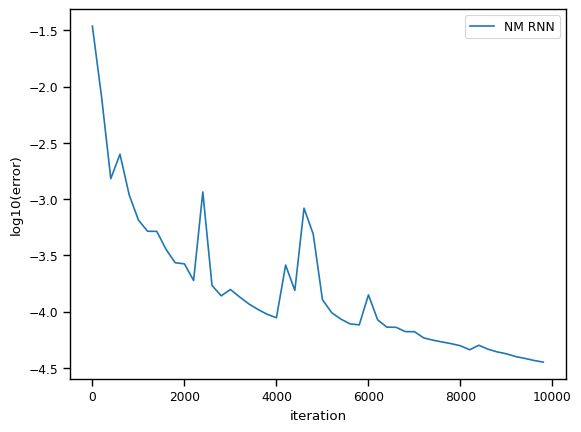

In [103]:
import numpy as np

loss_curve_nm = [loss[-1] for loss in losses_nm]
# loss_curve_vanilla = [loss[-1] for loss in losses_vanilla]
x_axis = np.arange(len(losses_nm)) * 200

plt.cla()
plt.plot(x_axis, np.log10(loss_curve_nm), label='NM RNN')
# plt.plot(x_axis, np.log10(loss_curve_vanilla), label='Vanilla RNN')
plt.ylabel('log10(error)')
plt.xlabel('iteration')
plt.legend()
plt.show()

In [105]:
all_inputs, all_outputs, all_masks = mwg_tasks(config['T'],
           jnp.array([[8, 10, 12, 14, 16, 18, 20, 22]]),
            15, 16,
            config['delay'],)

def align_to_go(data, inputs):
    """
    align data to go cue
    data: shape (8, 110, N) or (8, 110)
    return: shape (8, 60, N) or (8, 60)
    """
    go_cues = jnp.where(inputs[:,:,2])[1]
    go_mask = jnp.zeros((12, 110), dtype=bool)
    ind_range = jnp.arange(110)

    new_data = []
    for i in range(8):
        go_mask = (ind_range > go_cues[i] - 20) * (ind_range < go_cues[i] + 40)
        new_data.append(data[i, go_mask])
    new_data = jnp.stack(new_data)

    return new_data

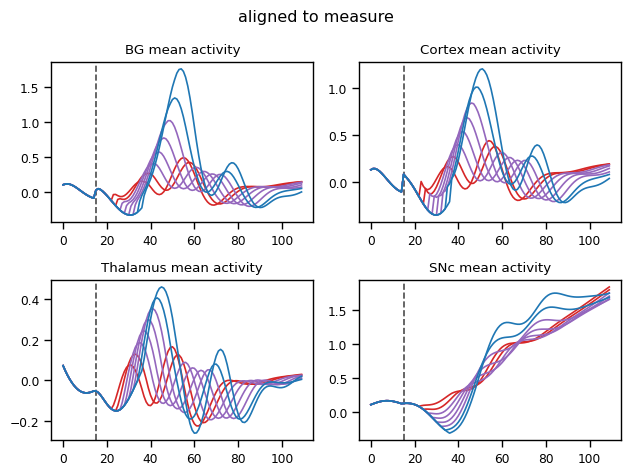

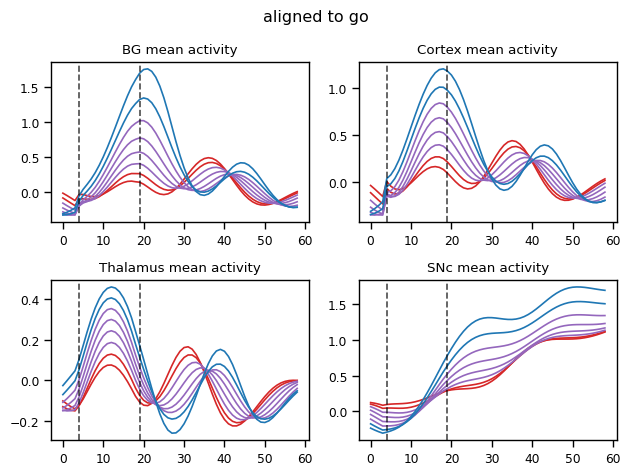

In [106]:
# plt.cla()
ys, xs, zs = batched_nm_rnn(params_nm, x0, z0, all_inputs, config['tau_x'], config['tau_z'], True)
for idx, name in enumerate(['BG', 'Cortex', 'Thalamus', 'SNc']):
    ax = plt.subplot(2, 2, idx + 1)
    mean_act = jnp.mean(xs[idx], axis=2) if idx < 3 else jnp.mean(zs, axis=2)
    ax.axvline(x=15, c='k', ls='--', alpha=0.7)
    ax.plot(mean_act[:2].T, c='tab:red')
    ax.plot(mean_act[2:6].T, c='tab:purple')
    ax.plot(mean_act[6:].T, c='tab:blue')
    ax.set_title(name + ' mean activity')

plt.suptitle('aligned to measure')
plt.tight_layout()
plt.show()

# plt.cla()
for idx, name in enumerate(['BG', 'Cortex', 'Thalamus', 'SNc']):
    ax = plt.subplot(2, 2, idx + 1)

    mean_act = jnp.mean(xs[idx], axis=2) if idx < 3 else jnp.mean(zs, axis=2)
    mean_act = align_to_go(mean_act, all_inputs)

    ax.plot(mean_act[:2].T, c='tab:red')
    ax.plot(mean_act[2:6].T, c='tab:purple')
    ax.plot(mean_act[6:].T, c='tab:blue')
    ax.axvline(x=4, c='k', ls='--', alpha=0.7)
    ax.axvline(x=19, c='k', ls='--', alpha=0.7)
    ax.set_title(name + ' mean activity')

plt.suptitle('aligned to go')
plt.tight_layout()
plt.show()

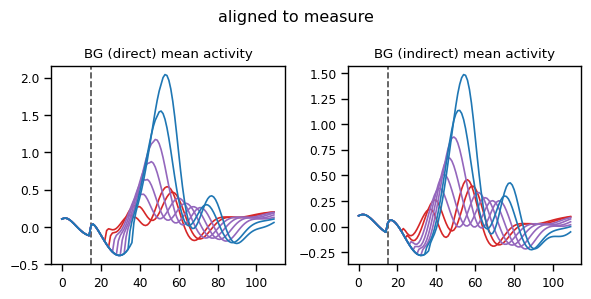

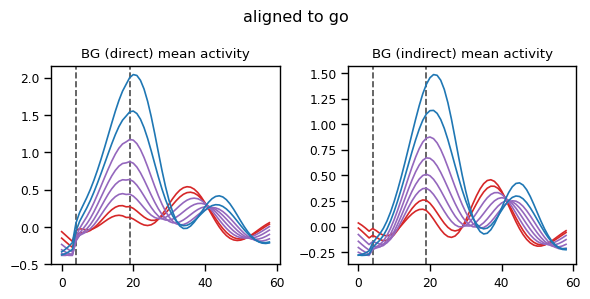

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ys, xs, zs = batched_nm_rnn(params_nm, x0, z0, all_inputs, config['tau_x'], config['tau_z'], True)
for idx, name in enumerate(['BG (direct)', 'BG (indirect)']):
    mean_act = jnp.mean(xs[0][:,:,10*idx:10*(idx+1)], axis=2)
    ax[idx].axvline(x=15, c='k', ls='--', alpha=0.7)
    ax[idx].plot(mean_act[:2].T, c='tab:red')
    ax[idx].plot(mean_act[2:6].T, c='tab:purple')
    ax[idx].plot(mean_act[6:].T, c='tab:blue')
    ax[idx].set_title(name + ' mean activity')

plt.suptitle('aligned to measure')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6,3))
for idx, name in enumerate(['BG (direct)', 'BG (indirect)']):
    mean_act = jnp.mean(xs[0][:,:,10*idx:10*(idx+1)], axis=2)
    mean_act = align_to_go(mean_act, all_inputs)

    ax[idx].axvline(x=4, c='k', ls='--', alpha=0.7)
    ax[idx].axvline(x=19, c='k', ls='--', alpha=0.7)
    ax[idx].plot(mean_act[:2].T, c='tab:red')
    ax[idx].plot(mean_act[2:6].T, c='tab:purple')
    ax[idx].plot(mean_act[6:].T, c='tab:blue')
    ax[idx].set_title(name + ' mean activity')

plt.suptitle('aligned to go')
plt.tight_layout()
plt.show()

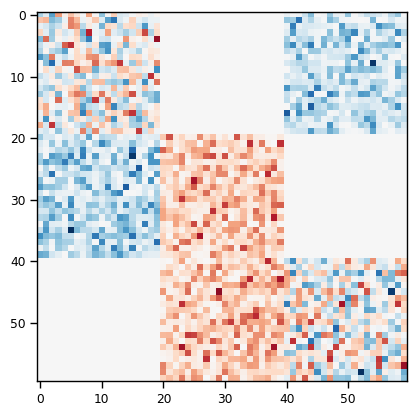

In [87]:
def exc(w):
    return jnp.abs(w)

def inh(w):
    return -jnp.abs(w)

c_weights = jnp.concatenate((params_nm['J_c'], jnp.zeros_like(params_nm['J_c']), exc(params_nm['B_ct'])), axis=1)
bg_weights = jnp.concatenate((exc(params_nm['B_bgc']), inh(params_nm['J_bg']), jnp.zeros_like(params_nm['J_bg'])), axis=1)
t_weights = jnp.concatenate((jnp.zeros_like(params_nm['J_t']), inh(params_nm['B_tbg']), params_nm['J_t']), axis=1)

full_weights = jnp.concatenate((c_weights, bg_weights, t_weights), axis=0)
plt.imshow(full_weights, cmap='RdBu', vmax=1, vmin=-1)

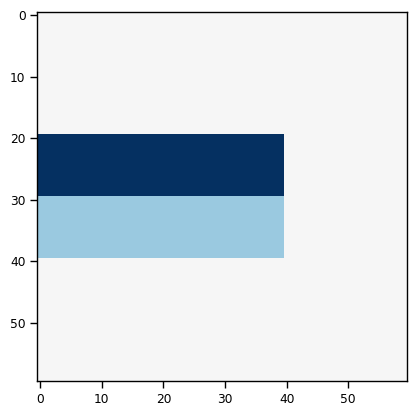

In [40]:
num_bg_cells=20
U = jnp.concatenate((jnp.ones((num_bg_cells//2, 1)), -1*jnp.ones((num_bg_cells//2, 1)))) # direct/indirect
V_bg = jnp.ones((num_bg_cells, 1))
V_c = jnp.ones((num_bg_cells, 1))
s = 1 # neuromodulatory signal (1D for now)
G_bg = jnp.exp(s * U @ V_bg.T)
G_c = jnp.exp(s * U @ V_c.T)

row_1_nm_weights = jnp.zeros((20, 60))
row_2_nm_weights = jnp.concatenate((G_c, G_bg, jnp.zeros_like(G_c)), axis=1)
full_nm_weights = jnp.concatenate((row_1_nm_weights, row_2_nm_weights, row_1_nm_weights), axis=0)
plt.imshow(full_nm_weights, cmap='RdBu', vmax=1, vmin=-1)

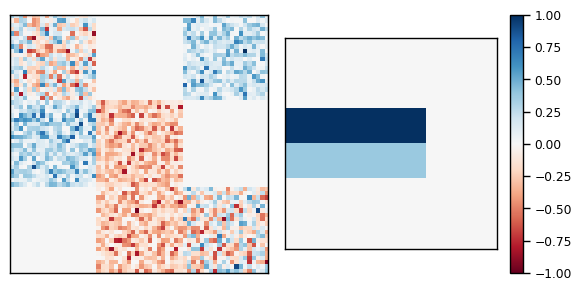

In [53]:
import seaborn as sns
sns.set_context("paper")

# make panels a decent size for 7.5" text width
fig, ax = plt.subplots(1,2,figsize=(6,3)) 
ax[0].imshow(full_weights, cmap='RdBu', vmax=1, vmin=-1)
ax[0].set_xticks([])
ax[0].set_yticks([])

ims = ax[1].imshow(full_nm_weights, cmap='RdBu', vmax=1, vmin=-1)
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ims, ax=ax[1])

plt.tight_layout()
plt.savefig("weight_matrices.pdf", dpi=500)


(8, 110, 1)


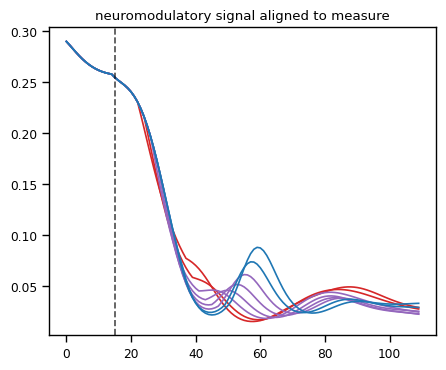

Text(0.5, 1.0, 'neuromodulatory signal aligned to go')

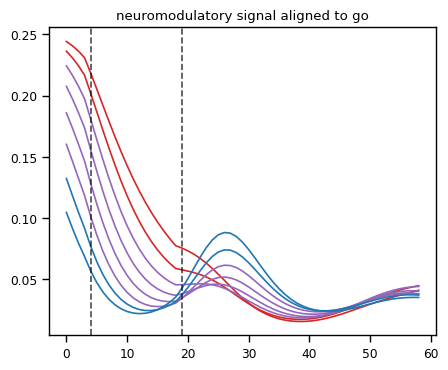

In [93]:
ys, xs, zs = batched_nm_rnn(params_nm, x0, z0, all_inputs, config['tau_x'], config['tau_z'], True)
nm_signal = jax.nn.sigmoid(zs @ params['m'].T + params['c'])
print(nm_signal.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.plot(nm_signal[:2,:,0].T, c='tab:red')
plt.plot(nm_signal[2:6,:,0].T, c='tab:purple')
plt.plot(nm_signal[6:,:,0].T, c='tab:blue')
ax.axvline(x=15, c='k', ls='--', alpha=0.7)
plt.title('neuromodulatory signal aligned to measure')
plt.show()

nm_signal_aligned = align_to_go(nm_signal, all_inputs)

colors = ['tab:red']*2 + ['tab:purple']*4 + ['tab:blue']*2
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i in range(8):
    plt.plot(nm_signal_aligned[i, :, 0], color=colors[i])
ax.axvline(x=4, c='k', ls='--', alpha=0.7)
ax.axvline(x=19, c='k', ls='--', alpha=0.7)
plt.title('neuromodulatory signal aligned to go')

In [ ]:
ys, xs, zs = batched_nm_rnn(params_nm, x0, z0, all_inputs, config['tau_x'], config['tau_z'], True)
plt.figure(figsize=(5, 4))
plt.plot(all_outputs[:,:,0].T, linestyle='--', c='k', alpha=0.5)
plt.plot(ys[:2,:,0].T, c='tab:red')
plt.plot(ys[2:6,:,0].T, c='tab:purple')
plt.plot(ys[6:,:,0].T, c='tab:blue')
plt.title('outputs')
plt.show()

ys, xs, zs = batched_nm_rnn(params_nm, x0, z0, all_inputs, config['tau_x'], config['tau_z'], False)
plt.figure(figsize=(5, 4))
plt.plot(all_outputs[:,:,0].T, linestyle='--', c='k', alpha=0.5)
plt.plot(ys[:2,:,0].T, c='tab:red')
plt.plot(ys[2:6,:,0].T, c='tab:purple')
plt.plot(ys[6:,:,0].T, c='tab:blue')
plt.title('outputs (remove modulation)')
plt.show()

NameError: name 'batched_nm_rnn' is not defined

# "syllable" task

In [150]:
# parameters we want to track in wandb
config = dict(
    # model parameters
    n_bg = 25,
    n_nm = 5,      # NM (SNc) dimension
    g_bg = 1.4,
    g_nm = 1.4,
    U = 2,      # input dim
    O = 1,      # output dimension
    # Model Hyperparameters
    tau_x = 10,
    tau_z = 100,
    # Timing (task) parameters
    dt = 10, # ms
    # Data Generation
    T = 500,
    num_syllables = 3,
    num_taus = 3,
    # Training
    num_full_train_iters = 2_000,
    keyind = 13,
)

def generate_syn_syllables(key, T, num_syllables, num_taus, trans_syl, trans_tau):
    # generate syllables
    syllables = jnp.zeros((T,), dtype=int)
    taus = jnp.zeros((T,), dtype=int)
    outputs = jnp.zeros((T,))
    tau_vals = jnp.logspace(-1,1,num_taus,base=2)

    for i in range(1, T):
        key, key2 = jr.split(key, 2)
        syllables = syllables.at[i].set(jr.choice(key, jnp.arange(num_syllables), p=trans_syl[syllables[i - 1], :]))
        if syllables[i] == syllables[i-1]:
            taus = taus.at[i].set(taus[i-1])
        else:
            taus = taus.at[i].set(jr.choice(key2, jnp.arange(num_taus), p=trans_tau[taus[i - 1], :]))
        if syllables[i] == 0:
            outputs = outputs.at[i].set(1)
        elif syllables[i] == 1:
            outputs = outputs.at[i].set(jnp.sin(tau_vals[taus[i]] * jnp.pi * (i/100)))
        else: outputs = outputs.at[i].set(jnp.cos(tau_vals[taus[i]] * jnp.pi * (i/100)))

    return outputs, syllables, taus

In [151]:
z_stay = 0.99
transition_z = z_stay*jnp.eye(config['num_syllables']) + (1-z_stay)/(config['num_syllables']-1)\
*(jnp.ones((config['num_syllables'],config['num_syllables']))-jnp.eye(config['num_syllables']))

tau_stay = 0.5
transition_tau = tau_stay*jnp.eye(config['num_taus']) + (1-tau_stay)/(config['num_taus']-1)\
*(jnp.ones((config['num_taus'],config['num_taus']))-jnp.eye(config['num_taus']))

ys, zs, ts = generate_syn_syllables(jr.PRNGKey(0), config['T'], config['num_syllables'], config['num_taus'], transition_z, transition_tau)

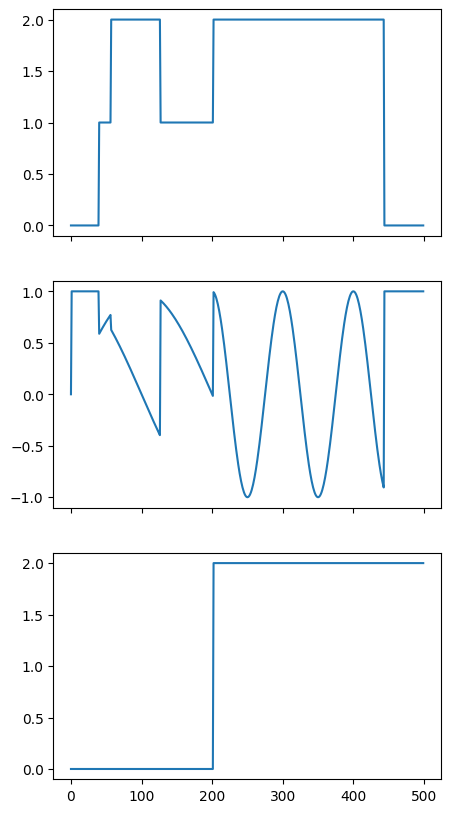

In [152]:
fig, ax = plt.subplots(3, 1, figsize=(5, 10), sharex=True)

ax[0].plot(zs)
ax[1].plot(ys)
ax[2].plot(ts)

# Logiaco et al tasks

In [153]:
import scipy.io as sio
import numpy as np

patterns_mat = sio.loadmat('oscill_patterns.mat')['patterns']

patterns = []

for i in range(5):
    for j in range(2):
        patterns.append(patterns_mat[i][j])

In [169]:
def generate_laureline_syllables(key, sequence_len, syl_patterns, num_syllables, num_taus, prep_delay=50):
    # generate syllables
    syllables = []
    taus = []
    outputs = []

    for i in range(1, sequence_len):
        key, key2 = jr.split(key, 2)
        this_syllable = jr.choice(key, jnp.arange(num_syllables))
        this_tau = jr.choice(key2, jnp.arange(num_taus)) + 1

        taus.append(0.5*this_tau*jnp.ones(prep_delay))
        syllables.append(0.5*(this_syllable+1)*jnp.ones(prep_delay))
        outputs.append(jnp.zeros(prep_delay))

        syl_len = (syl_patterns[this_syllable][0, ::this_tau]).shape
        outputs.append(syl_patterns[this_syllable][0, ::this_tau])
        taus.append(jnp.zeros(syl_len))
        syllables.append(jnp.zeros(syl_len))

    outputs = jnp.concatenate(outputs)
    taus = jnp.concatenate(taus)
    syllables = jnp.concatenate(syllables)

    return outputs, syllables, taus

outputs, syllables, taus = generate_laureline_syllables(jr.PRNGKey(13), 100, patterns, 3, 3)

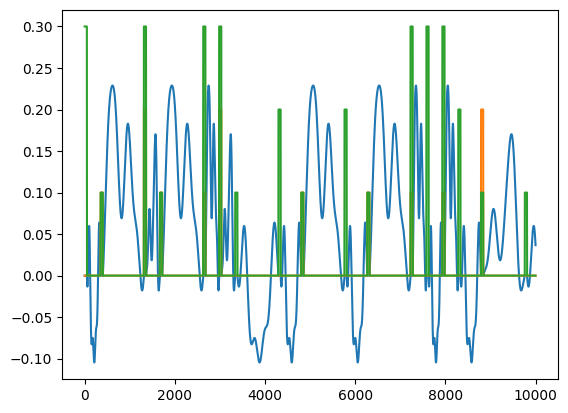

In [170]:
plt.plot(outputs[:10000])
plt.plot(syllables[:10000])
plt.plot(taus[:10000])

In [171]:
config = dict(
    # model parameters
    n_bg = 20,
    n_nm = 5,      # NM (SNc) dimension
    g_bg = 1.4,
    g_nm = 1.4,
    U = 2,      # input dim
    O = 1,      # output dimension
    # Model Hyperparameters
    tau_x = 10,
    tau_z = 100,
    # Data Generation
    num_syllables = 3,
    num_taus = 3,
    # Training
    num_full_train_iters = 1_000,
    keyind = 13,
)

key = jr.PRNGKey(config['keyind'])

# define a simple optimizer
optimizer = optax.chain(
  optax.clip(1.0), # gradient clipping
  optax.adamw(learning_rate=1e-3),
)

x_bg0 = jnp.ones((config['n_bg'],)) * 0.1
x_c0 = jnp.ones((config['n_bg'],)) * 0.1
x_t0 = jnp.ones((config['n_bg'],)) * 0.1
x0 = (x_bg0, x_c0, x_t0)
z0 = jnp.ones((config['n_nm'],)) * 0.1

# generate random initial parameters
params = init_params(
    key,
    config['n_bg'], config['n_nm'],
    config['g_bg'], config['g_nm'],
    config['U'], config['O']
)

outputs, syllables, taus = generate_laureline_syllables(jr.PRNGKey(13), 10, patterns, 3, 1)

outputs = jnp.stack((outputs, outputs), axis=0)[:,:,None]
inputs = jnp.stack((jnp.stack((syllables, syllables), axis=0), jnp.stack((taus, taus), axis=0)), axis=2)
masks = jnp.ones_like(outputs)

# train on all params
params_nm, losses_nm = fit_mwg_nm_rnn(inputs, outputs, masks,
                                params, optimizer, x0, z0, config['num_full_train_iters'],
                                config['tau_x'], config['tau_z'], wandb_log=False, modulation=True)

step 200, loss: nan


KeyboardInterrupt: 

In [157]:
ys, xs, zs = batched_nm_rnn(params_nm, x0, z0, inputs, config['tau_x'], config['tau_z'], True)

# new nm-rnn formulation

$$ \tau \frac{dx}{dt} = -x + W(t) \phi(x) + Bu \\ W(t) = W_{syn} \odot G(t) \\ G(t) = \sigma\left(U\textrm{diag}\left(s(t)\right)V^\top\right) $$

In [ ]:
def syn_nm_rnn(params, x0, z0, inputs, tau_x, tau_z, nln=jnp.tanh):
    """
    Arguments:
    - params
    - x0
    - inputs
    - tau   : decay constant
    """

    # main network params
    W_syn = params["static_recurrence"] # D x D
    B_xu = params["input_weights"]     # D x M
    C = params["readout_weights"]   # O x D
    rb = params["readout_bias"]             # O

    # nm network params
    W_zz = params["nm_rec_weight"]         # dim_nm x dim_nm
    B_zu = params["nm_input_weight"]      # dim_nm x M
    U = params["nm_row_factors"]       # D x R
    V = params["nm_column_factors"]    # D x R
    m = params["nm_sigmoid_weight"]         # R x dim_nm
    c = params["nm_sigmoid_intercept"]      # R

    N = x0.shape[0]

    def _step(x_and_z, u):
        x, z = x_and_z

        # update z
        z = (1.0 - (1. / tau_z)) * z + (1. / tau_z) * W_zz @ nln(z)
        z += (1. / tau_z) * B_zu @ u

        # calculate G(t)
        s = m @ z + c # effective nm signal
        G = jax.nn.sigmoid((U * s) @ V.T)

        # update x
        xp = x # hold onto previous value
        x = (1.0 - (1. / tau_x)) * xp # decay term
        x += (1. / (tau_x)) * (W_syn * G) @ xp
        x += (1. / tau_x) * B_xu @ u

        # calculate y
        y = C @ x + rb
        return (x, z), (y, x, z)

    _, (ys, xs, zs) = lax.scan(_step, (x0, z0), inputs)

    return ys, xs, zs

batched_syn_nm_rnn = vmap(syn_nm_rnn, in_axes=(None, None, None, 0, None, None))

def batched_syn_nm_rnn_loss(params, x0, z0, batch_inputs, tau_x, tau_z, batch_targets, batch_mask):
    ys, _, _ = batched_syn_nm_rnn(params, x0, z0, batch_inputs, tau_x, tau_z)
    return jnp.sum(((ys - batch_targets)**2)*batch_mask)/jnp.sum(batch_mask)

In [ ]:
def random_syn_nmrnn_params(key, u, n, r, m, o, g=1.0):
    """Generate random syn-nm-RNN parameters

    Arguments:
    u:  number of inputs
    n:  number of neurons in main network
    r:  rank of neuromodulatory effect
    m:  number of neurons in NM network
    o:  number of outputs
    """
    skeys = jr.split(key, 10)
    #   hscale = 0.1
    ifactor = 1.0 / jnp.sqrt(u) # scaling of input weights
    hfactor = g / jnp.sqrt(n) # scaling of recurrent weights
    pfactor = 1.0 / jnp.sqrt(n) # scaling of output weights

    return {'static_recurrence' : jr.normal(skeys[0], (n,n))*hfactor,
            'input_weights' : jr.normal(skeys[1], (n,u))*ifactor,
            'readout_weights' : jr.normal(skeys[2], (o,n))*pfactor,
            'readout_bias' : jr.normal(skeys[3], (o,))*pfactor,

            'nm_rec_weight' : jr.normal(skeys[4], (m,m))*0.1,
            'nm_input_weight' : jr.normal(skeys[5], (m,u))*ifactor,
            'nm_row_factors' : jr.normal(skeys[6],(n,r)) * 0.1,
            'nm_column_factors' : jr.normal(skeys[7],(n,r))*0.1,
            'nm_sigmoid_weight' : jr.normal(skeys[8], (r,m))*0.1,
            'nm_sigmoid_intercept' : jr.normal(skeys[9], (r,))*0.1
            }

In [ ]:
def fit_syn_nm_rnn(inputs, targets, loss_masks, params, optimizer, x0, z0, num_iters, tau_x, tau_z,
                   wandb_log=False, log_interval=200): # training on full set of data
    opt_state = optimizer.init(params)
    N_data = inputs.shape[0]

    @jit
    def _step(params_and_opt, input):
        (params, opt_state) = params_and_opt
        loss_value, grads = jax.value_and_grad(batched_syn_nm_rnn_loss)(params, x0, z0, inputs, tau_x, tau_z, targets, loss_masks)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), (params, loss_value)

    losses = []

    best_loss = 1e6
    best_params = params
    for n in range(num_iters//log_interval):
        (params,_), (_, loss_values) = lax.scan(_step, (params, opt_state), None, length=log_interval) #arange bc the inputs aren't changing
        losses.append(loss_values)
        print(f'step {(n+1)*200}, loss: {loss_values[-1]}')
        if wandb_log: wandb.log({'loss':loss_values[-1]})
        if wandb_log: wandb.log({'loss':loss_values[-1]})
        if loss_values[-1] < best_loss:
            best_params = params
            best_loss = loss_values[-1]

    return best_params, losses

In [ ]:
# parameters we want to track in wandb
default_config = dict(
    # model parameters
    U = 3,      # input dim
    O = 1,      # output dimension
    N = 50,    # main network dim
    M = 10,     # nm network dim
    R = 3,      # rank of nm effect
    # Model Hyperparameters
    tau_x = 10,
    tau_z = 100,
    # Timing (task) parameters
    dt = 10, # ms
    # Data Generation
    T = 110,
    measure_min = 10,
    measure_max = 20,
    intervals = [[12, 14, 16, 18]],
    delay = 15,
    # Training
    num_nm_only_iters = 0,
    num_full_train_iters = 4000,
    keyind = 13,
)

config = default_config

all_inputs, all_outputs, all_masks = mwg_tasks(config['T'],
           jnp.array(config['intervals']),
            config['measure_min'],
            config['measure_max'],
            config['delay'],)

key = jr.PRNGKey(config['keyind'])

# define a simple optimizer
optimizer = optax.chain(
  optax.clip(1.0), # gradient clipping
  optax.adamw(learning_rate=1e-3),
)

x0 = jnp.ones((config['N'],)) * 0.1
z0 = jnp.ones((config['M'],)) * 0.1

# generate random initial parameters
params = random_syn_nmrnn_params(key, config['U'], config['N'], config['R'],
                                 config['M'], config['O'])

params, losses = fit_syn_nm_rnn(all_inputs, all_outputs, all_masks,
                                params, optimizer, x0, z0, config['num_full_train_iters'],
                                config['tau_x'], config['tau_z'], wandb_log=False)

step 200, loss: 0.002778381574898958
step 400, loss: 0.0012279574293643236
step 600, loss: 0.0009141945047304034
step 800, loss: 0.0008076679077930748
step 1000, loss: 0.0007268108893185854
step 1200, loss: 0.0006580300396308303
step 1400, loss: 0.0006135084549896419
step 1600, loss: 0.0005831138696521521
step 1800, loss: 0.0005576643743552268
step 2000, loss: 0.0005337553448043764
step 2200, loss: 0.000511842779815197
step 2400, loss: 0.0004918859922327101
step 2600, loss: 0.0004739388532470912
step 2800, loss: 0.0004601305699907243
step 3000, loss: 0.0004479266353882849
step 3200, loss: 0.000439739873399958
step 3400, loss: 0.0004313893732614815
step 3600, loss: 0.00042367083369754255
step 3800, loss: 0.00041445172973908484
step 4000, loss: 0.00040528757381252944


In [ ]:

all_inputs, all_outputs, all_masks = mwg_tasks(config['T'],
           jnp.array([[8, 10, 12, 14, 16, 18, 20, 22]]),
            15,
            16,
            config['delay'],)

ys, xs, zs = batched_syn_nm_rnn(params, x0, z0, all_inputs, config['tau_x'], config['tau_z'])

Text(0.5, 1.0, 'outputs')

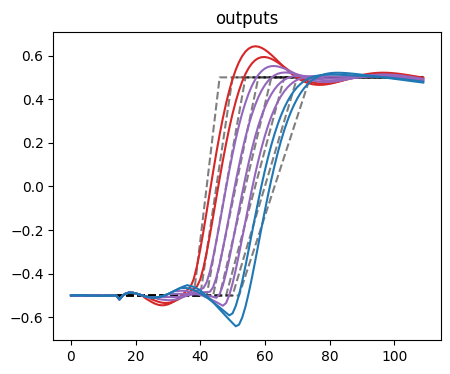

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(all_outputs[:,:,0].T, linestyle='--', c='k', alpha=0.5)
plt.plot(ys[:2,:,0].T, c='tab:red')
plt.plot(ys[2:6,:,0].T, c='tab:purple')
plt.plot(ys[6:,:,0].T, c='tab:blue')
plt.title('outputs')

Text(0.5, 1.0, 's(t) aligned to measure cue')

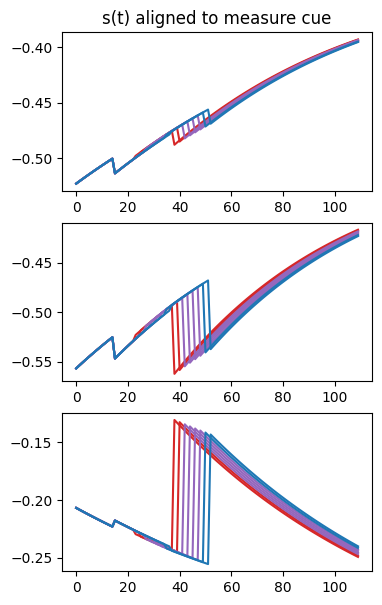

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(4,7))

colors = ['tab:red']*2 + ['tab:purple']*4 + ['tab:blue']*2
for i in range(8):
    nm_signal = (params['nm_sigmoid_weight'] @ zs[i].T + params['nm_sigmoid_intercept'][0,None])
    ax[0].plot(nm_signal[0], c=colors[i])
    ax[1].plot(nm_signal[1], c=colors[i])
    ax[2].plot(nm_signal[2], c=colors[i])
ax[0].set_title('s(t) aligned to measure cue')

In [ ]:
def align_to_go_single(data, inputs):
    """
    align data to go cue
    data: shape (110, N)
    return: shape (60, N)
    """
    go_cue = jnp.where(inputs[:,2])[0]

    ind_range = jnp.arange(110)

    new_data = []
    go_mask = (ind_range > (go_cue - 20)) * (ind_range < (go_cue + 40))
    new_data = data[:, go_mask]

    return new_data

Text(0.5, 1.0, 's(t) aligned to go cue')

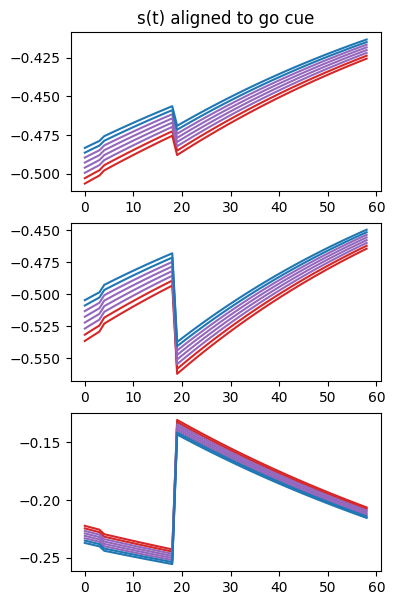

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(4,7))

colors = ['tab:red']*2 + ['tab:purple']*4 + ['tab:blue']*2
for i in range(8):
    nm_signal = (params['nm_sigmoid_weight'] @ zs[i].T + params['nm_sigmoid_intercept'][0,None])
    nm_signal = align_to_go_single(nm_signal, all_inputs[i])
    ax[0].plot(nm_signal[0], c=colors[i])
    ax[1].plot(nm_signal[1], c=colors[i])
    ax[2].plot(nm_signal[2], c=colors[i])

ax[0].set_title('s(t) aligned to go cue')